<a href="https://colab.research.google.com/github/jarek-pawlowski/machine-learning-applications/blob/main/pytorch_albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import cv2

import albumentations as A

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

Dowload a dataset using *torchvision* and create dataloader. 

In [3]:
transform = transforms.ToTensor()
train_subset = datasets.MNIST('../data', train=True, download=True, transform=transform)
loader_kwargs = {'batch_size': 128, 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = DataLoader(train_subset)

Load images from the dataset and save as separate images.

In [4]:
dataset_directory = os.path.join('./', "dataset")
os.makedirs(dataset_directory, exist_ok=True)
images_filepaths = []
images_labels = []
for i, (image, label) in enumerate(train_loader):
    filepath = os.path.join(dataset_directory, str(i)+".png")
    cv2.imwrite(filepath, image.numpy()[0,0]*255)  # png can only store in uint8 type (while float not)
    images_filepaths.append(filepath)
    images_labels.append(label.item())

Now define dataset with some *albumentations*.

In [5]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image.dtype == 'uint8': image = image.astype('float32')/255.  # return to float
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image[None,...], label


albumentations_transform = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip()
])

albumentations_dataset = AlbumentationsDataset(
    file_paths=images_filepaths,
    labels=images_labels,
    transform=albumentations_transform,
)

Plot sample images after augmentation

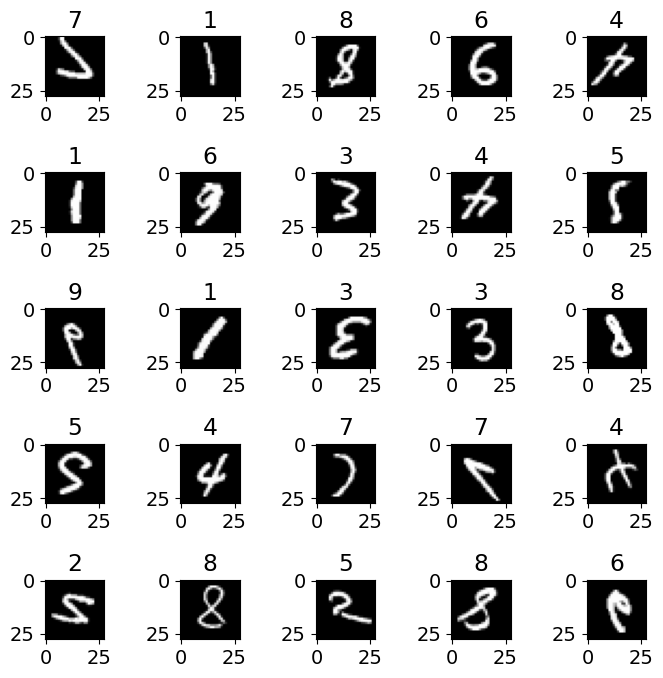

In [6]:
example_number = 123
fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(albumentations_dataset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(albumentations_dataset[example_number+i*5+j][1])

Note that the default transformation probability is 0.5